### imports

In [1]:
import random
import os
import csv
import tqdm

import numpy as np

from PIL import Image
import matplotlib.pyplot as plt
import imageio

import nltk
from nltk.translate.bleu_score import corpus_bleu
from nltk.translate.meteor_score import meteor_score
from pycocoevalcap.cider.cider import Cider

import torch
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pad_sequence
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms as T
import torchvision.models as models
from sklearn.model_selection import train_test_split

import kagglehub

In [2]:
class Colour:
    BLUE = '\033[94m'
    CYAN = '\033[96m'
    GREEN = '\033[92m'
    YELLOW = '\033[93m'
    RED = '\033[91m'
    BOLD = '\033[1m'
    END = '\033[0m'

vscode_bg = '#1e1e1e'
text_color = 'white'
grid_color = '#444444'

plt.rcParams['font.family'] = 'monospace'
plt.rcParams['font.monospace'] = ['Consolas', 'DejaVu Sans Mono', 'Courier New']
plt.rcParams['figure.facecolor'] = vscode_bg
plt.rcParams['axes.facecolor'] = vscode_bg
plt.rcParams['axes.edgecolor'] = text_color
plt.rcParams['axes.labelcolor'] = text_color
plt.rcParams['xtick.color'] = text_color
plt.rcParams['ytick.color'] = text_color
plt.rcParams['text.color'] = text_color
plt.rcParams['grid.color'] = grid_color

# Preprocess

### load data

In [3]:
path = kagglehub.dataset_download("eeshawn/flickr30k")
print("Path to dataset files:", path)
nltk.download('punkt_tab')

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

Path to dataset files: /Users/valentin/.cache/kagglehub/datasets/eeshawn/flickr30k/versions/1


[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/valentin/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


### prepare data

In [4]:
class Vocab:
    def __init__(self):
        self.word2idx = {}
        self.idx2word = {}
        self.idx = 0
        # specials tokens
        self.add_word('<pad>')
        self.add_word('<unk>')
        self.add_word('<start>')
        self.add_word('<end>')

    def add_word(self, word):
        if word not in self.word2idx:
            self.word2idx[word] = self.idx
            self.idx2word[self.idx] = word
            self.idx += 1

    def __len__(self):
        return len(self.word2idx)

    def encode(self, text):
        tokens = nltk.tokenize.word_tokenize(text.lower())
        return [self.word2idx.get(t, self.word2idx['<unk>']) for t in tokens]

In [5]:
class CaptionDataset(Dataset):
    def __init__(self, data_pairs, vocab, cache_dir):
        self.data_pairs = data_pairs
        self.vocab = vocab
        self.cache_dir = cache_dir
        
    def __len__(self): return len(self.data_pairs)
    
    def __getitem__(self, idx):
        img_path, caption = self.data_pairs[idx]
        filename = os.path.basename(img_path).split('.')[0] + ".pt"
        load_path = os.path.join(self.cache_dir, filename)
        
        try:
            cached = torch.load(load_path)
            feat = cached['features'] if isinstance(cached, dict) else cached
            if len(feat.shape) > 1: feat = feat[0]
        except FileNotFoundError:
            feat = torch.zeros(512) # fallback

        tokens = self.vocab.encode(caption)
        caption_indices = [self.vocab.word2idx['<start>']] + tokens + [self.vocab.word2idx['<end>']]
        return feat, torch.tensor(caption_indices, dtype=torch.long)

In [6]:
class DataManager:
    def __init__(self, dataset_path, img_folder_name="flickr30k_images", captions_filename="captions.txt", cache_dir="cached_features"):
        self.root = dataset_path
        self.img_folder = os.path.join(self.root, img_folder_name)
        self.captions_file = self._find_file(captions_filename)
        self.token_file = os.path.join(self.root, "flickr30k.token.txt")
        self.cache_dir = cache_dir
        self.vocab = Vocab()
        self.data_pairs = []
        
    def _find_file(self, name):
        for root, _, files in os.walk(self.root):
            if name in files: return os.path.join(root, name)
        return None

    def prepare_data(self, limit=None, vocab_max_size=None):
        """Pipeline complet : CSV -> Token -> Vocab -> Pairs"""
        if not os.path.exists(self.token_file):
            self._convert_csv_to_token()
            
        with open(self.token_file, 'r', encoding='utf-8') as f:
            lines = f.readlines()
            
        random.seed(42)
        random.shuffle(lines)
        
        count = 0
        for line in lines:
            if limit and count >= limit: break
            
            parts = line.strip().split('\t')
            if len(parts) < 2: continue
            
            img_id = parts[0].split('#')[0]
            caption = parts[1]
            img_path = os.path.join(self.img_folder, img_id)
            
            if os.path.exists(img_path):
                self.data_pairs.append((img_path, caption))
                for w in nltk.tokenize.word_tokenize(caption.lower()):
                    if vocab_max_size and len(self.vocab) >= vocab_max_size: continue
                    self.vocab.add_word(w)
                count += 1
                
        print(f"{Colour.GREEN}✅ Data loaded:{Colour.END} {Colour.BOLD}{len(self.data_pairs)}{Colour.END} pairs | {Colour.BOLD}{len(self.vocab)}{Colour.END} vocab words")

    def _convert_csv_to_token(self):
        try:
            with open(self.captions_file, 'r', encoding='utf-8') as infile, \
                 open(self.token_file, 'w', encoding='utf-8') as outfile:
                reader = csv.reader(infile)
                next(reader)
                for row in reader:
                    if len(row) == 3:
                        outfile.write(f"{row[0]}#{row[1]}\t{row[2]}\n")
        except Exception as e:
            print(f"{Colour.RED}❌ Conversion error:{Colour.END} {e}")
    
    def caption_collate_fn(self, batch):
        imgs, caps = zip(*batch)
        imgs = torch.stack(imgs)
        caps_padded = pad_sequence(caps, batch_first=True, padding_value=0)
        return imgs, caps_padded

    def get_loaders(self, batch_size=64, test_size=0.2):
        """Divise par IMAGE et renvoie les DataLoaders"""
        img_to_caps = {}
        for img, cap in self.data_pairs:
            if img not in img_to_caps: img_to_caps[img] = []
            img_to_caps[img].append(cap)
            
        unique_imgs = list(img_to_caps.keys())
        train_imgs, test_imgs = train_test_split(unique_imgs, test_size=test_size, random_state=42)
        
        train_pairs = [(img, cap) for img in train_imgs for cap in img_to_caps[img]]
        test_pairs = [(img, cap) for img in test_imgs for cap in img_to_caps[img]]
        
        print(f"{Colour.CYAN}📊 Split:{Colour.END} Train {Colour.BOLD}{len(train_pairs)}{Colour.END} | Test {Colour.BOLD}{len(test_pairs)}{Colour.END}")
        
        train_ds = CaptionDataset(train_pairs, self.vocab, self.cache_dir)
        test_ds = CaptionDataset(test_pairs, self.vocab, self.cache_dir)
        
        train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, collate_fn=self.caption_collate_fn, drop_last=True)
        test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False, collate_fn=self.caption_collate_fn, drop_last=True)
        
        return train_loader, test_loader, train_pairs, test_pairs


In [7]:
data_manager = DataManager(path)
data_manager.prepare_data(limit=26000, vocab_max_size=5000)
train_loader, test_loader, train_pairs, test_pairs = data_manager.get_loaders(batch_size=100)
vocab = data_manager.vocab

✅ Data loaded: 26000 pairs | 5000 vocab words
📊 Split: Train 20855 | Test 5145


In [8]:
weights = torchvision.models.detection.FasterRCNN_ResNet50_FPN_Weights.DEFAULT
resnet = torchvision.models.detection.fasterrcnn_resnet50_fpn(weights=weights).to(DEVICE)   # pretrained=True
resnet.eval()

print(f"{Colour.GREEN}✅ Models loaded{Colour.END}")
print(f"💻 Device: {Colour.YELLOW}{DEVICE.upper()}{Colour.END}")

✅ Models loaded
💻 Device: CPU


# Load model

In [9]:
class CaptioningModel(nn.Module):
    def __init__(self, vocab_size, embed_dim, image_feature_dim, hidden_size, dropout_prob=0.5):
        super().__init__()
        self.image_projection = nn.Linear(image_feature_dim, embed_dim)
        self.word_embedding = nn.Embedding(vocab_size, embed_dim)
        self.lstm = nn.LSTM(input_size=embed_dim + embed_dim, hidden_size=hidden_size, batch_first=True)
        self.output_projection = nn.Linear(hidden_size, vocab_size)
        self.dropout = nn.Dropout(dropout_prob)

    def forward(self, image_features, captions):
        img_emb = self.image_projection(image_features) # [Batch, Embed_Dim]
        img_emb = F.relu(img_emb)
        
        word_embeds = self.word_embedding(captions)     # [Batch, Seq_Len, Embed_Dim]
        word_embeds = self.dropout(word_embeds)
        
        seq_len = word_embeds.size(1)
        img_emb_expanded = img_emb.unsqueeze(1).expand(-1, seq_len, -1)
        
        lstm_inputs = torch.cat((word_embeds, img_emb_expanded), dim=2) 
        lstm_out, _ = self.lstm(lstm_inputs)
        
        return self.output_projection(lstm_out)

    def sample(self, image_features, vocab, max_len=20, temperature=1.0, device='cpu'):
        self.eval()
        with torch.no_grad():
            img_emb = self.image_projection(image_features)
            img_emb = F.relu(img_emb)
            img_emb = img_emb.unsqueeze(1) 
            
            hidden = None 
            start_token = vocab.word2idx.get('<start>', vocab.word2idx.get('<unk>', 1))
            current_input_idx = torch.tensor([start_token]).long().to(device).unsqueeze(0) # [1, 1]
            
            generated_ids = []
            
            for i in range(max_len):
                word_emb = self.word_embedding(current_input_idx) # [1, 1, Embed_Dim]

                lstm_input = torch.cat((word_emb, img_emb), dim=2) # [1, 1, Embed_Dim * 2]
                lstm_out, hidden = self.lstm(lstm_input, hidden)
                outputs = self.output_projection(lstm_out) # [1, 1, Vocab]
                
                probs = F.softmax(outputs[0, 0] / temperature, dim=0)
                
                if temperature == 0:
                    next_word_idx = torch.argmax(probs).item()
                else:
                    next_word_idx = torch.multinomial(probs, 1).item()
                
                if next_word_idx == vocab.word2idx.get('<end>', 0):
                    break
                
                generated_ids.append(next_word_idx)
                current_input_idx = torch.tensor([next_word_idx]).long().to(device).unsqueeze(0)
                
            tokens = [vocab.idx2word.get(idx, '<unk>') for idx in generated_ids]
            return " ".join(tokens)

In [10]:
VOCAB_SIZE = len(vocab)
EMBED_DIM = 512
HIDDEN_SIZE = 512
IMG_FEAT_DIM = 2048

In [11]:
file_saved_model = 'saved_models/captioning_model_epoch40.pth'

checkpoint = torch.load(file_saved_model, map_location=DEVICE)
model_captioning = CaptioningModel(VOCAB_SIZE, EMBED_DIM, IMG_FEAT_DIM, HIDDEN_SIZE).to(DEVICE)
model_captioning.load_state_dict(checkpoint['model_state_dict'])
optimizer_captioning = torch.optim.RMSprop(model_captioning.parameters(), lr=1e-4)
optimizer_captioning.load_state_dict(checkpoint['optimizer_state_dict'])
vocab.word2idx = checkpoint['vocab_word2idx']
vocab.idx2word = checkpoint['vocab_idx2word']
train_losses = checkpoint['train_losses']
epoch = checkpoint['epoch']
print(f"{Colour.GREEN}✅ Pretrained model loaded from {Colour.BOLD}{file_saved_model}{Colour.END}")

criterion_captioning = nn.CrossEntropyLoss(ignore_index=vocab.word2idx.get('<pad>', 0))

print(f"💻 Device: {Colour.YELLOW}{DEVICE.upper()}{Colour.END}")

✅ Pretrained model loaded from saved_models/captioning_model_epoch40.pth
💻 Device: CPU


# Scores computation

### BLEU score

In [12]:
def get_bleu_score(test_pairs, vocab, model_captioning, device, cache_dir="cached_features", temperature=0.3, verbose=True):
    if verbose:
        print(f"\n{Colour.CYAN}🔍 Calculating BLEU scores on test set... {Colour.YELLOW}(T={temperature}){Colour.END}")
    
    img_to_refs = {}
    for img_path, caption in test_pairs:
        if img_path not in img_to_refs:
            img_to_refs[img_path] = []
        img_to_refs[img_path].append(nltk.tokenize.word_tokenize(caption.lower()))
    
    references = []
    hypotheses = []

    model_captioning.eval()
    
    for img_path, refs in tqdm.tqdm(img_to_refs.items(), desc="Generating captions"):
        filename = os.path.basename(img_path).split('.')[0] + ".pt"
        load_path = os.path.join(cache_dir, filename)
        try:
            features = torch.load(load_path)['features']
            img_vector = (features[0] if features.ndim > 1 else features).unsqueeze(0).to(device)
        except FileNotFoundError:
            continue

        generated_text = model_captioning.sample(img_vector, vocab, max_len=20, temperature=temperature, device=device)
        generated_tokens = nltk.tokenize.word_tokenize(generated_text.lower())
        references.append(refs)
        hypotheses.append(generated_tokens)

    bleu1 = corpus_bleu(references, hypotheses, weights=(1.0, 0, 0, 0))
    bleu2 = corpus_bleu(references, hypotheses, weights=(0.5, 0.5, 0, 0))
    bleu3 = corpus_bleu(references, hypotheses, weights=(0.33, 0.33, 0.33, 0))
    bleu4 = corpus_bleu(references, hypotheses, weights=(0.25, 0.25, 0.25, 0.25))

    if verbose:
        print(f"\n{Colour.GREEN}🏆 Results BLEU :{Colour.END}")
        print(f"   • BLEU-1 = {Colour.BOLD}{bleu1*100:.2f}{Colour.END}")
        print(f"   • BLEU-2 = {Colour.BOLD}{bleu2*100:.2f}{Colour.END}")
        print(f"   • BLEU-3 = {Colour.BOLD}{bleu3*100:.2f}{Colour.END}")
        print(f"   • BLEU-4 = {Colour.BOLD}{bleu4*100:.2f}{Colour.END}")
    
    return bleu1, bleu2, bleu3, bleu4

### METEOR score

In [13]:
def get_meteor_score(test_pairs, vocab, model_captioning, device, cache_dir="cached_features", temperature=0.3, verbose=True):
    if verbose:
        print(f"\n{Colour.CYAN}🔍 Calculating METEOR scores on test set... {Colour.YELLOW}(T={temperature}){Colour.END}")
    
    img_to_refs = {}
    for img_path, caption in test_pairs:
        if img_path not in img_to_refs:
            img_to_refs[img_path] = []
        img_to_refs[img_path].append(nltk.tokenize.word_tokenize(caption.lower()))
    
    references = []
    hypotheses = []

    model_captioning.eval()
    
    for img_path, refs in tqdm.tqdm(img_to_refs.items(), desc="Generating captions"):
        filename = os.path.basename(img_path).split('.')[0] + ".pt"
        load_path = os.path.join(cache_dir, filename)
        try:
            features = torch.load(load_path)['features']
            img_vector = (features[0] if features.ndim > 1 else features).unsqueeze(0).to(device)
        except FileNotFoundError:
            continue

        generated_text = model_captioning.sample(img_vector, vocab, max_len=20, temperature=temperature, device=device)
        generated_tokens = nltk.tokenize.word_tokenize(generated_text.lower())
        references.append(refs)
        hypotheses.append(generated_tokens)

    meteor_scores = [meteor_score(refs, generated_tokens) for refs, generated_tokens in zip(references, hypotheses)]
    avg_meteor = np.mean(meteor_scores)
    if verbose:
        print(f"\n{Colour.GREEN}🏆 Results METEOR :{Colour.END}")
        print(f"   • METEOR = {Colour.BOLD}{avg_meteor*100:.2f}{Colour.END}")
    
    return avg_meteor

### CIDEr score

In [14]:
def get_cider_score_coco(test_pairs, vocab, model, device, cache_dir="cached_features", temperature=0.3, verbose=True):
    if verbose:
        print(f"{Colour.CYAN}🔍 Calculating CIDEr scores on test set...{Colour.END}")
    gts = {}
    res = {}
    scorer = Cider() 
    model.eval()
    
    for idx, (img_path, caption) in enumerate(tqdm.tqdm(test_pairs, desc="Generating")):
        image_id = img_path
        if image_id not in gts:
            gts[image_id] = []
        gts[image_id].append(caption)
        
        if image_id not in res:
            filename = os.path.basename(img_path).split('.')[0] + ".pt"
            load_path = os.path.join(cache_dir, filename)
            try:
                features = torch.load(load_path)['features']
                img_vector = (features[0] if features.ndim > 1 else features).unsqueeze(0).to(device)
            except FileNotFoundError:
                continue

            generated_text = model.sample(img_vector, vocab, max_len=20, temperature=temperature, device=device)
            clean_text = generated_text.replace("<start>", "").replace("<end>", "").replace("<pad>", "").strip()
            res[image_id] = [clean_text]

    avg_score, scores = scorer.compute_score(gts, res)
    if verbose:
        print(f"\n{Colour.GREEN}🏆 Results CIDEr :{Colour.END}")
        print(f"   • CIDEr = {Colour.BOLD}{avg_score:.4f}{Colour.END}")
    
    return avg_score

### plot function

In [15]:
def plot_metrics(x_data, metrics_dict, title, y_label, colors=None):
    
    fig, ax = plt.subplots(figsize=(10, 6), facecolor=vscode_bg)
    ax.set_facecolor(vscode_bg)

    for i, (label, y_values) in enumerate(metrics_dict.items()):
        color = colors[i] if colors and i < len(colors) else None
        plt.plot(x_data, y_values, linewidth=1.5, label=label, color=color)

    plt.xlabel('Temperature', fontsize=14, color=text_color)
    plt.ylabel(y_label, fontsize=14, color=text_color)
    plt.title(title, fontsize=16, color=text_color, pad=20)

    ax.tick_params(axis='both', colors=text_color, labelsize=11, length=6, width=1.2)

    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_color(text_color)
    ax.spines['left'].set_linewidth(1.2)
    ax.spines['bottom'].set_color(text_color)
    ax.spines['bottom'].set_linewidth(1.2)

    plt.grid(True, which='major', linestyle='-', linewidth=0.8, alpha=0.2, color='white')

    legend = plt.legend(loc='upper right', fontsize=12, frameon=False)
    for text in legend.get_texts():
        text.set_color(text_color)

    plt.xticks(x_data)
    ax.set_xlim(0, max(x_data) if len(x_data) > 0 else 1)
    ax.set_ylim(0, None)

    plt.tight_layout()
    plt.show()

### computation...

In [16]:
temperatures = [0.0, 0.1, 0.2, 0.3, 0.5, 1.0, 1.5]
bleu1_results = []
bleu2_results = []
bleu3_results = []
bleu4_results = []
for temperature in temperatures:
    bleu1, bleu2, bleu3, bleu4 = get_bleu_score(test_pairs, vocab, model_captioning, temperature=temperature, device=DEVICE, verbose=False)
    bleu1_results.append(bleu1 * 100)
    bleu2_results.append(bleu2 * 100)
    bleu3_results.append(bleu3 * 100)
    bleu4_results.append(bleu4 * 100)

Generating captions: 100%|██████████| 3770/3770 [00:23<00:00, 160.74it/s]


In [17]:
temperatures = [0.0, 0.1, 0.2, 0.3, 0.5, 1.0, 1.5]
meteor_results = []
for temperature in temperatures:
    meteor = get_meteor_score(test_pairs, vocab, model_captioning, temperature=temperature, device=DEVICE, verbose=False)
    meteor_results.append(meteor * 100)

Generating captions: 100%|██████████| 3770/3770 [00:25<00:00, 149.16it/s]


In [18]:
temperatures = [0.0, 0.1, 0.2, 0.3, 0.5, 1.0, 1.5]
cider_results = []
for temperature in temperatures:
    cider = get_cider_score_coco(test_pairs, vocab, model_captioning, temperature=temperature, device=DEVICE, verbose=False)
    cider_results.append(cider * 100)

Generating: 100%|██████████| 5145/5145 [00:24<00:00, 210.26it/s]


# Visualization

### BLEU Score

The BLEU-$n$ score evaluates precision by calculating the fraction of $n$-grams (sequences of $n$ words) in the generated caption that appear in the reference captions. It includes a Brevity Penalty (BP) to prevent the model from artificially boosting its score by generating overly short sentences. The BLEU score is computed using the formula:

$$\text{BLEU} = \text{BP} \cdot \exp\left(\sum_{n=1}^{N} w_n \log p_n\right)$$

where $p_n$ is the precision for $n$-grams, $w_n$ are weights (often uniform), and BP is defined as:

$$\text{BP} = \begin{cases} 1 & \text{if } c > r \\ e^{(1 - r/c)} & \text{if } c \leq r \end{cases}$$

with $c$ being the length of the candidate caption and $r$ the length of the reference captions.

Interpretation: The score ranges from 0 to 1 (or 0 to 100). A high BLEU score indicates high lexical fidelity, meaning the model reproduces exact words and phrases found in the human references. However, it does not account for synonyms or sentence meaning.

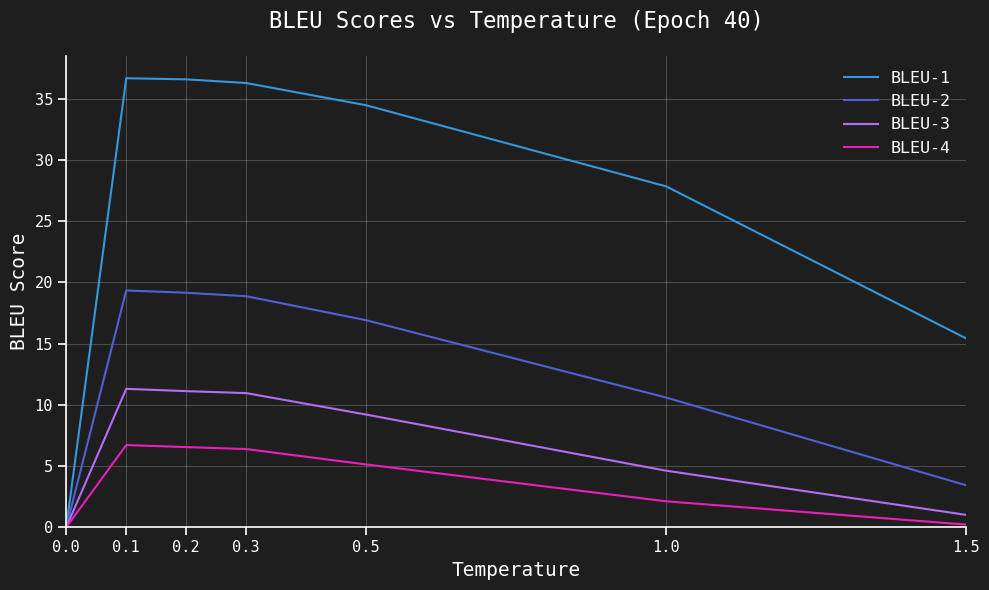

In [19]:
bleu_data = {
    'BLEU-1': bleu1_results,
    'BLEU-2': bleu2_results,
    'BLEU-3': bleu3_results,
    'BLEU-4': bleu4_results
}
bleu_colors = ['#3498db', '#5160d3', '#b36df5', '#e91ebd']

plot_metrics(x_data=temperatures, metrics_dict=bleu_data, title=f'BLEU Scores vs Temperature (Epoch {epoch})', y_label='BLEU Score', colors=bleu_colors)

### METEOR score

Definition: METEOR calculates the harmonic mean of unigram precision and recall. Unlike BLEU, it aligns words based not only on exact matches but also on stemming (root forms) and synonyms (using WordNet). It also applies a penalty for poor ordering (fragmentation) of the matched words. The METEOR score is computed as:

$$\text{METEOR} = F_{mean} \cdot (1 - Penalty)$$

where $F_{mean}$ is the harmonic mean of precision and recall, and the Penalty is calculated based on the number of chunks (contiguous matched sequences) in the alignment.

Interpretation: The score ranges from 0 to 1. METEOR generally correlates better with human judgment than BLEU because it rewards the use of relevant synonyms and correct grammatical structure, rather than just exact word-for-word matching.

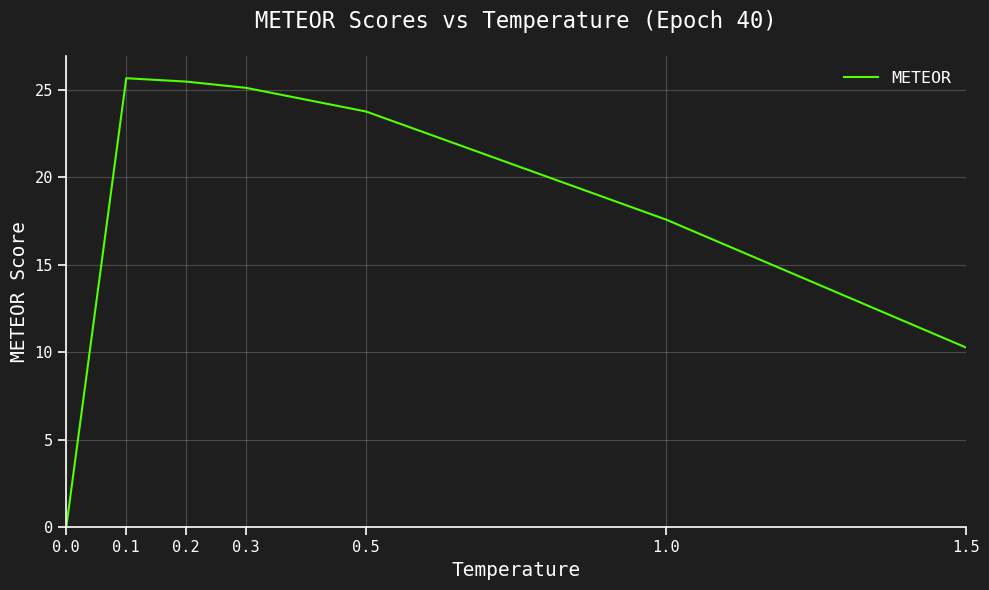

In [20]:
plot_metrics(x_data=temperatures, metrics_dict={'METEOR': meteor_results}, title=f'METEOR Scores vs Temperature (Epoch {epoch})', y_label='METEOR Score', colors=['#51ff00'])

### CIDEr score

Definition: Designed specifically for Image Captioning, CIDEr measures the consensus between the generated caption and the references using TF-IDF (Term Frequency-Inverse Document Frequency) weighting. This ensures that creating a sentence with informative, rare words (visual concepts) is weighted higher than using common, non-informative words. The CIDEr score is computed as:

$$\text{CIDEr} = \frac{1}{m} \sum_{i=1}^{m} \frac{g \cdot r_i}{\|g\| \|r_i\|}$$

where $g$ is the TF-IDF vector of the generated caption, $r_i$ are the TF-IDF vectors of the reference captions, and $m$ is the number of reference captions.

Interpretation: The CIDEr score is not bounded by 1 (it can typically range from 0 to 3 or more). A high score indicates that the model has successfully captured the key visual concepts and salient information of the image that the majority of human annotators agreed upon.

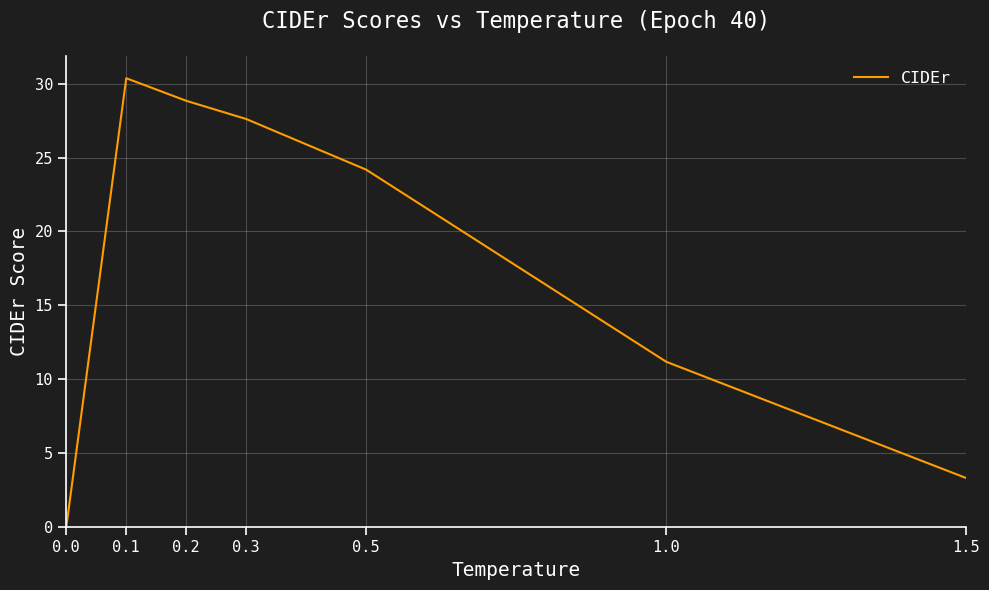

In [21]:
plot_metrics(x_data=temperatures, metrics_dict={'CIDEr': cider_results}, title=f'CIDEr Scores vs Temperature (Epoch {epoch})', y_label='CIDEr Score', colors=['#ff9d00'])

In [22]:
epochs = [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 110]

✅ Loaded epoch 0


Generating: 100%|██████████| 5145/5145 [00:30<00:00, 171.14it/s]


✅ Loaded epoch 10


Generating: 100%|██████████| 5145/5145 [00:25<00:00, 201.84it/s]


✅ Loaded epoch 20


Generating: 100%|██████████| 5145/5145 [00:25<00:00, 205.03it/s]


✅ Loaded epoch 30


Generating: 100%|██████████| 5145/5145 [00:24<00:00, 206.92it/s]


✅ Loaded epoch 40


Generating: 100%|██████████| 5145/5145 [00:23<00:00, 220.78it/s]


✅ Loaded epoch 50


Generating: 100%|██████████| 5145/5145 [00:24<00:00, 212.83it/s]


✅ Loaded epoch 60


Generating: 100%|██████████| 5145/5145 [00:23<00:00, 219.98it/s]


✅ Loaded epoch 70


Generating: 100%|██████████| 5145/5145 [00:22<00:00, 229.99it/s]


✅ Loaded epoch 80


Generating: 100%|██████████| 5145/5145 [00:23<00:00, 220.73it/s]


✅ Loaded epoch 90


Generating: 100%|██████████| 5145/5145 [00:24<00:00, 210.67it/s]


✅ Loaded epoch 100


Generating: 100%|██████████| 5145/5145 [00:22<00:00, 230.76it/s]


✅ Loaded epoch 110


Generating: 100%|██████████| 5145/5145 [00:22<00:00, 225.18it/s]


AttributeError: 'FigureCanvasAgg' object has no attribute 'tostring_rgb'

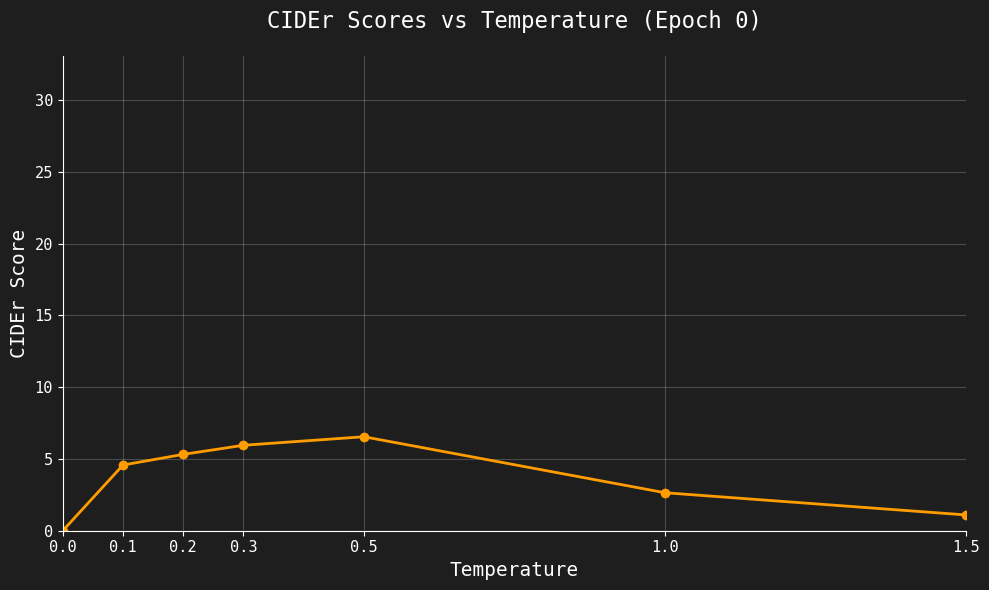

In [23]:
all_cider_results = {}

for ep in epochs:
    file_saved_model = f'saved_models/captioning_model_epoch_{ep}.pth'
    
    checkpoint = torch.load(file_saved_model, map_location=DEVICE)
    model_captioning = CaptioningModel(VOCAB_SIZE, EMBED_DIM, IMG_FEAT_DIM, HIDDEN_SIZE).to(DEVICE)
    model_captioning.load_state_dict(checkpoint['model_state_dict'])
    vocab.word2idx = checkpoint['vocab_word2idx']
    vocab.idx2word = checkpoint['vocab_idx2word']
    print(f"{Colour.GREEN}✅ Loaded epoch {ep}{Colour.END}")

    temperatures = [0.0, 0.1, 0.2, 0.3, 0.5, 1.0, 1.5]
    cider_results = []
    for temperature in temperatures:
        cider = get_cider_score_coco(test_pairs, vocab, model_captioning, temperature=temperature, device=DEVICE, verbose=False)
        cider_results.append(cider * 100)
    
    all_cider_results[ep] = cider_results

# # Generate frames for the video
# frames = []
# for ep in epochs:
#     fig, ax = plt.subplots(figsize=(10, 6), facecolor=vscode_bg)
#     ax.set_facecolor(vscode_bg)
    
#     ax.plot(temperatures, all_cider_results[ep], linewidth=2, color='#ff9d00', marker='o')
    
#     ax.set_xlabel('Temperature', fontsize=14, color=text_color)
#     ax.set_ylabel('CIDEr Score', fontsize=14, color=text_color)
#     ax.set_title(f'CIDEr Scores vs Temperature (Epoch {ep})', fontsize=16, color=text_color, pad=20)
#     ax.tick_params(axis='both', colors=text_color, labelsize=11)
#     ax.spines['top'].set_visible(False)
#     ax.spines['right'].set_visible(False)
#     ax.spines['left'].set_color(text_color)
#     ax.spines['bottom'].set_color(text_color)
#     ax.grid(True, linestyle='-', linewidth=0.8, alpha=0.2, color='white')
#     ax.set_xlim(0, max(temperatures))
#     ax.set_ylim(0, max(max(v) for v in all_cider_results.values()) * 1.1)
#     ax.set_xticks(temperatures)
    
#     plt.tight_layout()
    
#     # Save frame to buffer
#     fig.canvas.draw()
#     frame = np.frombuffer(fig.canvas.tostring_rgb(), dtype=np.uint8)
#     frame = frame.reshape(fig.canvas.get_width_height()[::-1] + (3,))
#     frames.append(frame)
#     plt.close(fig)

# # Create video
# imageio.mimsave('cider_evolution.mp4', frames, fps=2)
# print(f"{Colour.GREEN}✅ Video saved as cider_evolution.mp4{Colour.END}")

    

In [27]:
# Generate frames for the video
frames = []
for ep in epochs:
    fig, ax = plt.subplots(figsize=(10, 6), facecolor=vscode_bg)
    ax.set_facecolor(vscode_bg)
    
    ax.plot(temperatures, all_cider_results[ep], linewidth=2, color='#ff9d00', marker='o')
    
    ax.set_xlabel('Temperature', fontsize=14, color=text_color)
    ax.set_ylabel('CIDEr Score', fontsize=14, color=text_color)
    ax.set_title(f'CIDEr Scores vs Temperature (Epoch {ep})', fontsize=16, color=text_color, pad=20)
    ax.tick_params(axis='both', colors=text_color, labelsize=11)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_color(text_color)
    ax.spines['bottom'].set_color(text_color)
    ax.grid(True, linestyle='-', linewidth=0.8, alpha=0.2, color='white')
    ax.set_xlim(0, max(temperatures))
    ax.set_ylim(0, max(max(v) for v in all_cider_results.values()) * 1.1)
    ax.set_xticks(temperatures)
    
    plt.tight_layout()
    
    # Save frame to buffer
    fig.canvas.draw()
    frame = np.asarray(fig.canvas.buffer_rgba())
    frame = frame[..., :3]
    frames.append(frame)
    plt.close(fig)

# Create video
try:
    with imageio.get_writer('cider_evolution.mp4', format='ffmpeg', fps=2) as writer:
        for frame in frames:
            writer.append_data(frame)
    print(f"{Colour.GREEN}✅ Video saved as cider_evolution.mp4{Colour.END}")
except Exception as e:
    imageio.mimsave('cider_evolution.gif', frames, fps=2)
    print(f"{Colour.YELLOW}⚠️ FFmpeg unavailable ({e}); saved GIF as cider_evolution.gif{Colour.END}")

⚠️ FFmpeg unavailable (The `FFMPEG` plugin is not installed. Use `pip install imageio[ffmpeg]` to install it.); saved GIF as cider_evolution.gif
